<a href="https://colab.research.google.com/github/LogicOber/ML4SCI/blob/main/Copy_of_ML4Sci_FNO(release_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subtask 01 - Data Exploration

Congratulations on making it this far! You’ve reached the final challenge of this homework series.

This notebook is designed as a helper tool to aid your understanding of the problem at hand. Take some time to explore it—you might find it interesting! 🚀

You are free to modify the code and experiment with new ideas. However, if you make any changes, please leave a comment explaining:
* Why you made this alteration
* How it improves or enhances the solution


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [ ]:
# Install the PyDrive wrapper & import libraries.
import re
import tarfile
import shutil
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import wandb

# @markdown Input file name
file_name = "data3.tar.gz"  # @param {type:"string"}
file_dir = os.path.join("/content")
file_path = os.path.join(
    file_dir,
    file_name)

# @markdown Choose file source - google drive or sharelink
source_type = "link"  # @param ["drive", "link"] {allow-input: false}

# Use Google link
if source_type == "link":
  print("Accessing file using pydrive from link...")
  # @markdown Copy your google drive file share link here
  google_drive_share_link = 'https://drive.google.com/file/d/11rVEeuwW9ujz-06WeVz2p1-17F2L0o8I/view?usp=sharing' # @param {type:"string"}
  file_id = re.search("/d/(.*?)/", google_drive_share_link).group(1)

  # Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Download file if it doesn't already exist
  if os.path.isfile(file_path):
      print(f'File {file_path} already exists.')
  else:
    print(f'File {file_path} does not exist. Downloading now...')
    downloaded_file = drive.CreateFile({'id': file_id})
    downloaded_file.GetContentFile(file_path)
    print('Download complete.')
# Use Mounted Drive
elif (source_type == "drive"):
  print("Accessing file using pydrive from google drive not impletemented")


# Extract the .tar file
if tarfile.is_tarfile(file_path):
    print('Extracting files...')
    with tarfile.open(file_path, "r") as tar:
        tar.extractall(file_dir)
    print('Extraction complete!')
else:
    print(f"{file_path} is not a valid tar file.")

Accessing file using pydrive from link...
File /content/data3.tar.gz does not exist. Downloading now...
Download complete.
Extracting files...
Extraction complete!


## 1.Load data into memory

In [ ]:
def load_data(data_path):
    data = np.load(data_path, allow_pickle=True).item()
    return data

In [ ]:
data_root = "/content/data/"
data_path = f"{data_root}train/data_05005.npy"

result = load_data(data_path)

for key, item in result.items():
    print(key, item.shape)

field_node (2051, 3)
coord (2051, 2)
edge_index_bi (2, 11858)
cell_node_list (3878, 3)
mask_bd (2051, 1)
mask_wall (2051, 1)
mask_inlet (2051, 1)
mask_outlet (2051, 1)
mask_object (2051, 1)


## 2. Data visulisation

In [ ]:
def visulise_data(data_path, cmap="jet"):
    zeta = 10

    data = load_data(data_path)

    coord = data.get("coord")
    face = data.get("cell_node_list")
    value = data.get("field_node")[:, 2] # here we are visulising the pressure field

    left, right = min(coord[:, 0]), max(coord[:, 0])
    bottom, top = min(coord[:, 1]), max(coord[:, 1])

    width = zeta * (right - left)
    height = zeta * (top - bottom)

    triangle = tri.Triangulation(coord[:, 0], coord[:, 1], face)

    fig, ax = plt.subplots(figsize=(width, height))

    ax.set_aspect("equal")
    ax.triplot(triangle, 'ko-', ms=0.1, lw=0.1)
    ax.tripcolor(triangle, value, cmap=cmap, alpha=0.4)

    return fig, ax

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

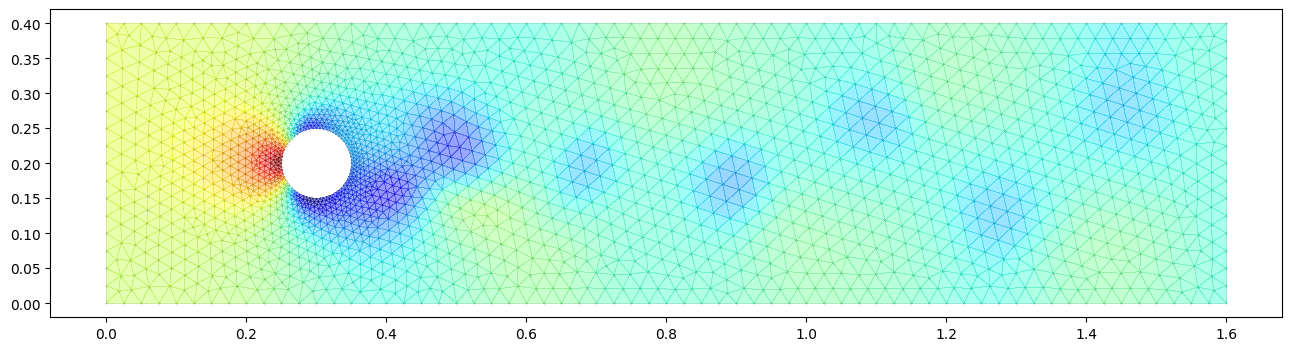

In [ ]:
visulise_data(data_path)

## 3. Data Statistics

In [ ]:
import glob
from natsort import natsorted

In [ ]:
# Make it a task
def get_mean_std(data_folder_path):
    data_list = []

    file_path = os.path.join(data_folder_path, "data_*.npy")
    file_names = glob.glob(file_path)
    file_names = natsorted(file_names)

    for file_name in file_names:
        data = load_data(file_name)
        data_list.append(data.get("field_node"))

    data = np.concatenate(data_list, axis=0)

    mean = np.mean(data, axis=0, keepdims=True)
    std = np.std(data, axis=0, keepdims=True)

    return mean, std


In [ ]:
mean, std = get_mean_std(f"{data_root}/train/")

## 4.Data interpolation and masking

In [ ]:
from scipy.interpolate import griddata


def get_grid_and_mask(data):

    r = 0.05
    x_center = 0.3
    y_center = 0.2

    grid_num_x = 320
    grid_num_y = 80

    coord = data.get("coord")
    field_node = data.get("field_node")

    x_min, x_max = min(coord[:, 0]), max(coord[:, 0])
    y_min, y_max = min(coord[:, 1]), max(coord[:, 1])

    x_coord, y_coord = np.meshgrid(
        np.linspace(x_min, x_max, grid_num_x),
        np.linspace(y_min, y_max, grid_num_y)
    )

    x_coord, y_coord = x_coord.flatten(), y_coord.flatten()

    # calculate mask
    dis_from_center = np.sqrt((x_coord - x_center)**2 + (y_coord - y_center)**2)
    mask = dis_from_center <= r

    grid_data = []
    num_dim = field_node.shape[1]
    for i in range(num_dim):
        grid_data_i = griddata(
            coord, field_node[:, i], (x_coord, y_coord), method='cubic'
        )

        grid_data_i[mask] = 0
        grid_data_i = grid_data_i.reshape(grid_num_y, grid_num_x)
        grid_data.append(grid_data_i)

    grid_data = np.stack(grid_data, axis=0)

    mask_grid = mask.reshape(1, grid_num_y, grid_num_x)

    return grid_data, mask_grid

In [ ]:
from tqdm import tqdm

def post_process(dataset_dir):
    file_names = glob.glob(os.path.join(dataset_dir, "data_*.npy"))
    file_names = natsorted(file_names)

    for file_name in tqdm(file_names, desc="Processing files"):
        data = load_data(file_name)
        grid_data, mask = get_grid_and_mask(data)
        data["field_conv"] = grid_data
        data["mask"] = mask
        np.save(file_name, data)

In [ ]:
post_process(dataset_dir = f"{data_root}/train/")

Processing files: 100%|██████████| 3000/3000 [05:55<00:00,  8.43it/s]


In [ ]:
post_process(dataset_dir = f"{data_root}/test/")

Processing files: 100%|██████████| 500/500 [00:59<00:00,  8.46it/s]


In [ ]:
post_process(dataset_dir = f"{data_root}/val_task3/")

Processing files: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


(3, 80, 320)


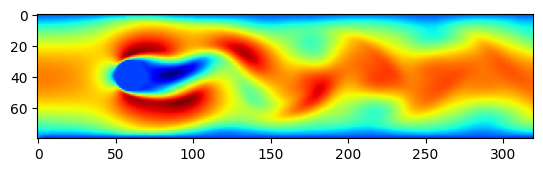

In [ ]:
data = load_data(data_path)

grid_data = data["field_conv"]
print(grid_data.shape)
plt.imshow(grid_data[0], cmap="jet")
plt.show()

# Subtask 02 - Dataset construction and Data Loading

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from natsort import natsorted
from scipy.interpolate import griddata

In [ ]:
import glob
class CNNDataset(Dataset):
    """
    A custom PyTorch dataset for loading spatiotemporal data in a format suitable for CNN-based models.

    This dataset handles time-series data stored in `.npy` files,
    The dataset loads consecutive time frames, applies transformations,
    and formats the data for training models.

    Args:
        dataset_dir (str, optional): Path to the directory containing `.npy` dataset files.
        t_dim (int, optional): The number of time steps to include per sample. Default is 10.
        transform (callable, optional): A function to apply transformations to input data.
        target_transform (callable, optional): A function to apply transformations to target data.

    Attributes:
        file_names (list): A sorted list of file paths to dataset files.
        t_dim (int): The number of time steps per sample.
        transform (callable): Transformation function for input data.
        target_transform (callable): Transformation function for target data.

    Task:
    - Implement `__len__`:
        - Compute the number of samples by dividing dataset length by `(2 * t_dim)`.
    - Implement `__getitem__`:
        - Compute index ranges for `in_data` and `out_data`.
        - Load and process the input-output data pairs.
        - Apply transformations if provided.
        - Stack time-series data along the temporal axis.
        - Ensure the final shape follows `(x1, x2, t, channel)` format. where x1 and x2 are spatial dimensions and t is the number of time steps.

    Note:
    - This dataset assumes `.npy` files contain dictionary-like data.
    - Set `t_dim == 10` based on the sequence length training.
    - Feel free to modify the preprocessing pipeline to fit specific model architectures - if that is necessary.
    """

    def __init__(self, dataset_dir=None, t_dim=10, transform=None, target_transform=None):
        self.t_dim=t_dim
        self.transform = transform
        self.target_transform = target_transform

        self.file_names = glob.glob(os.path.join(dataset_dir, "data_*.npy"))
        self.file_names = natsorted(self.file_names)

    def __len__(self):
      # Your code here
        return len(self.file_names) // (2 * self.t_dim)

    def load_data(self, data_path):
        data = np.load(data_path, allow_pickle=True).item()
        return data

    def __getitem__(self, idx):
        in_start_idx = idx * 2 * self.t_dim
        out_start_idx = in_start_idx + self.t_dim

        in_data_list = []
        out_data_list = []

        for i in range(self.t_dim):
            file_idx = in_start_idx + i
            data = self.load_data(self.file_names[file_idx])
            field_data = data["field_conv"]

            if self.transform:
                field_data = self.transform(field_data)

            in_data_list.append(field_data)

        for i in range(self.t_dim):
            file_idx = out_start_idx + i
            data = self.load_data(self.file_names[file_idx])
            field_data = data["field_conv"]

            if self.target_transform:
                field_data = self.target_transform(field_data)

            out_data_list.append(field_data)

        if isinstance(in_data_list[0], torch.Tensor):
            in_data = torch.stack(in_data_list, dim=0)
            out_data = torch.stack(out_data_list, dim=0)
        else:
            in_data = np.stack(in_data_list, axis=0)
            out_data = np.stack(out_data_list, axis=0)

        if isinstance(in_data, torch.Tensor):
            in_data = in_data.permute(2, 3, 0, 1)
            out_data = out_data.permute(2, 3, 0, 1)
        else:
            in_data = np.transpose(in_data, (2, 3, 0, 1))
            out_data = np.transpose(out_data, (2, 3, 0, 1))

        return in_data, out_data

In [ ]:
dataset_dir = f"{data_root}/test/"
print(dataset_dir)

dataset = CNNDataset(dataset_dir)
print(len(dataset))

idx = 20
sample, target = dataset[idx]
print(sample.shape, target.shape)

/content/data//test/
25
(80, 320, 10, 3) (80, 320, 10, 3)


## 2. Data Transformation

do 2 things - normalise and interpolate (with mask)

In [ ]:
class Normalise:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        data = (data - self.mean) / self.std
        return data


class ToFloatTransform:
    def __init__(self, scale=True):
        return

    def __call__(self, data):
        data = torch.from_numpy(data).float()
        return data


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        for transform in self.transforms:
            data = transform(data)
        return data

In [ ]:
transform = Compose([
    Normalise(mean = mean.reshape(-1, 1, 1),
              std = std.reshape(-1, 1, 1)),
    ToFloatTransform(),
])

dataset = CNNDataset(dataset_dir = dataset_dir, transform=transform, target_transform=transform)

idx = 0
data_in, target = dataset[idx]

conv_in = data_in
print(conv_in.shape)

torch.Size([80, 320, 10, 3])


## 3. Data Loader


In [ ]:
Loader = DataLoader(dataset=dataset, num_workers=4, batch_size=16)

# Subtask 03 - FNO

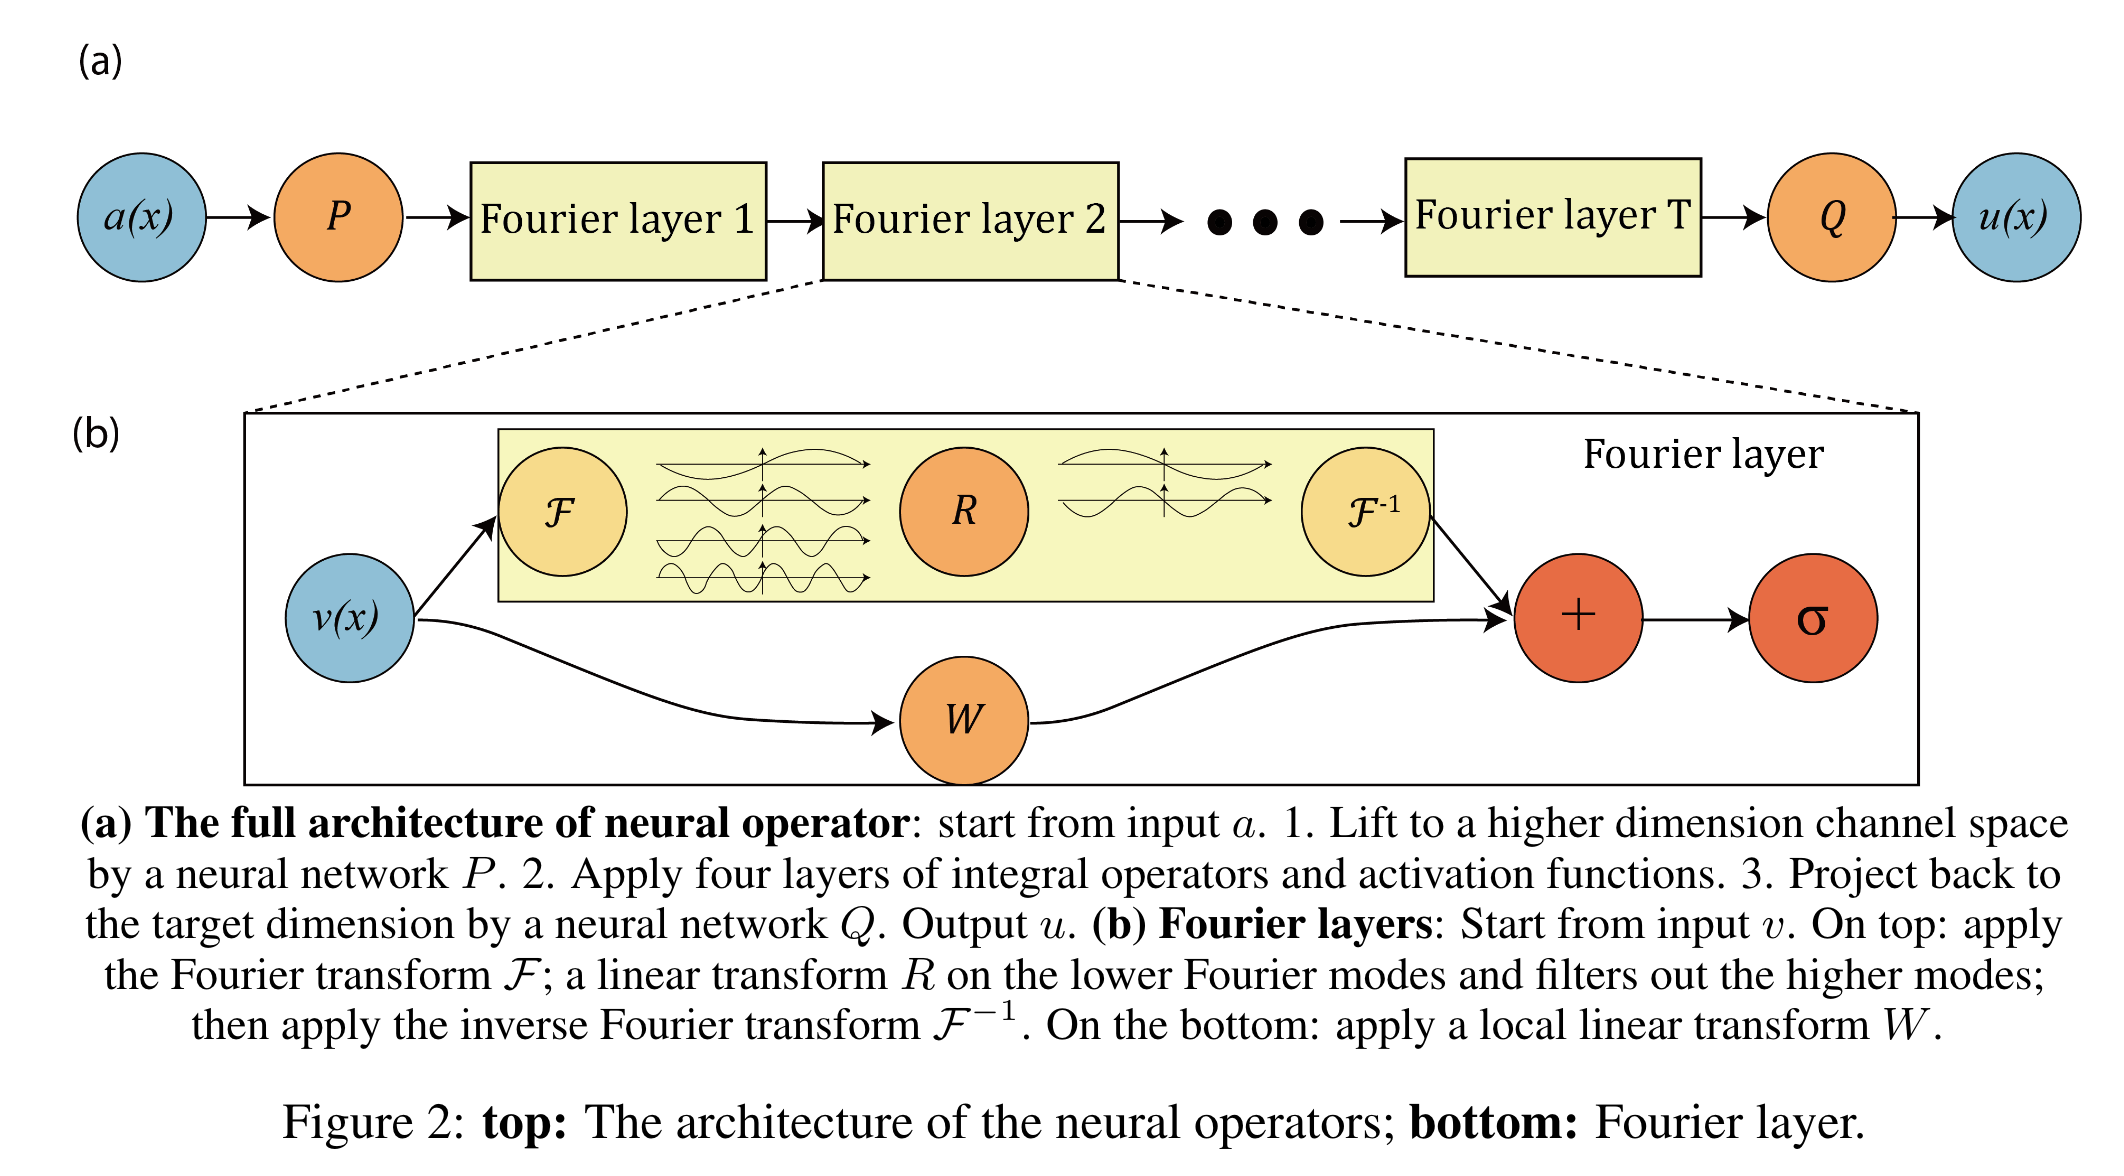

# Understanding `SpectralConv3d` Class

1. In the `class SpectralConv3d(nn.Module)` class, why we use `self.weights1, self.weights2 ...`

2. Why there is a 'self.scale = (1 / (in_channels * out_channels))` in the code? what is the purpose of this line?

3. What is the line `torch.einsum("bixyz,ioxyz->boxyz", input, weights)` doing here? Could you explain it? Could you also give a pytorch implementation with out einsum doing the same thing (porvide demo in the code cell below)? Why we want to use einsum?

4. Try to go through the `forward` methods, annotate this methods line by line explaining the purpose of each line.

## Your Answers here:
1.
...

In [ ]:
# Your code here

In [ ]:
from torch import nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()
        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x



class FNO3d(nn.Module):
    def __init__(self,
                 modes1=8,
                 modes2=8,
                 modes3=8,
                 width=36
                ):
        super(FNO3d, self).__init__()
        """
        3D Fourier Neural Operator (FNO) for solving PDEs in spatiotemporal domains.

        This model consists of three Fourier layers followed by point-wise feed-forward
        layers to learn complex spatial-temporal dependencies.

        Args:
            modes1 (int, optional): Number of Fourier modes to keep in the first dimension. Default is 8.
            modes2 (int, optional): Number of Fourier modes to keep in the second dimension. Default is 8.
            modes3 (int, optional): Number of Fourier modes to keep in the third (temporal) dimension. Default is 5.
            width (int, optional): Number of feature channels in Fourier and convolution layers. Default is 36.

        Attributes:
            fc0 (nn.Linear): Initial linear layer to project input channels to `width`.
            conv0, conv1, conv2 (SpectralConv3d): Spectral convolution layers for learning frequency representations.
            w0, w1, w2 (nn.Conv1d): Pointwise convolution layers for additional processing.
            fc1, fc2 (nn.Linear): Fully connected layers for post-processing.

        Task:
        - Implement the `forward` method:
            - Apply `fc0` to project input to `width` channels.
            - Use `permute` to rearrange dimensions for spectral convolutions.
            - Apply `conv0`, `conv1`, `conv2` sequentially, with `relu` activations.
            - Apply `w0`, `w1`, `w2` to perform pointwise transformations.
            - Pass through `fc1` and `fc2` to obtain final outputs.
        """
        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        """
        3 channels for velocity_x, velocity_y, pressure
        """
        self.fc0 = nn.Linear(3, self.width)
        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)

        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)

        x1 = self.conv0(x)
        x1 = F.relu(x1)
        x1 = self.w0(x1.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x + x1

        x1 = self.conv1(x)
        x1 = F.relu(x1)
        x1 = self.w1(x1.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x + x1

        x1 = self.conv2(x)
        x1 = F.relu(x1)
        x1 = self.w2(x1.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x + x1

        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
model = FNO3d(10, 10, 5)
dummy = torch.randn((8, 90, 320, 10, 3))
print(model(dummy).shape)

torch.Size([8, 90, 320, 10, 3])


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    avg_loss = 0.0
    for batch in loader:
        in_data, out_data = batch
        in_data, out_data = in_data.to(device), out_data.to(device)
        optimizer.zero_grad()
        pred = model(in_data)
        loss = criterion(pred, out_data)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss /= len(loader)
    return loss, model


def test_one_epoch(model, loader, criterion):
    model.eval()
    avg_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            in_data, out_data = batch
            in_data, out_data = in_data.to(device), out_data.to(device)
            pred = model(in_data)
            loss = criterion(pred, out_data)
            avg_loss += loss.item()
    avg_loss /= len(loader)
    return loss




def train(epoch, model, optimizer, loader_train, loader_test):
    criterion = torch.nn.MSELoss()
    model = model.to(device)
    for i in range(epoch):
        loss, model = train_one_epoch(
            model=model, loader=loader_train, optimizer=optimizer, criterion=criterion)
        print(f"Epoch \t{i+1}, Train Loss \t{loss}")
        if (i+1) % 50 == 0:
            info = test_one_epoch(
                model=model, loader=loader_test, criterion=criterion)
            print(f"\t Epoch \t{i+1}, Test Loss \t{loss}")
            model_path = os.path.join(
                os.path.abspath("."),
                f"epoch_{i+1}.pth"
            )
            torch.save(model.state_dict(), model_path)
            print(model_path, "saved")


##Model Training and Tuning

Key Considerations:

What is the role of modes1, modes2, and modes3?
> These parameters define the number of Fourier modes retained in each spatial dimension, controlling the spectral resolution of the model.

What loss function did you use to train the model?
> Specify the loss function(s) experimented with and justify the choice in terms of stability, convergence, and accuracy.

Model Tuning and Optimization Log:

Provide a concise summary of your model tuning process, including:
* Alterations made to the baseline model to improve performance.
* Hyperparameter adjustments and their impact.
* The most effective modification that led to the best overall results.

Clearly document your reasoning behind each change to demonstrate an iterative, data-driven approach to model optimization.

## Your Notes here:

In [ ]:
epoch = 100
lr = 1e-3
bs = 6

mode = 8
model = FNO3d(modes1 = mode, modes2=mode, modes3=4, width=36)

train_set = CNNDataset(
    dataset_dir = f"{data_root}/train/",
    transform=transform, target_transform=transform)
test_set = CNNDataset(
    dataset_dir = f"{data_root}/test/",
    transform=transform, target_transform=transform)

loader_train = DataLoader(train_set, batch_size=bs, num_workers=4)
loader_test = DataLoader(test_set, batch_size=bs, num_workers=4)

# Init optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=1e-6,
)

train(epoch=epoch, model=model, optimizer=optimizer, loader_train=loader_train, loader_test=loader_test)

Epoch 	1, Train Loss 	0.05393847078084946
Epoch 	2, Train Loss 	0.02011355385184288
Epoch 	3, Train Loss 	0.011931306682527065
Epoch 	4, Train Loss 	0.00746421841904521
Epoch 	5, Train Loss 	0.004859836306422949
Epoch 	6, Train Loss 	0.003385306801646948
Epoch 	7, Train Loss 	0.00254325894638896
Epoch 	8, Train Loss 	0.0020389286801218987
Epoch 	9, Train Loss 	0.0017136720707640052
Epoch 	10, Train Loss 	0.0014833103632554412
Epoch 	11, Train Loss 	0.0013158776564523578
Epoch 	12, Train Loss 	0.0011896105716004968
Epoch 	13, Train Loss 	0.0010913696605712175
Epoch 	14, Train Loss 	0.001012214575894177
Epoch 	15, Train Loss 	0.00094436394283548
Epoch 	16, Train Loss 	0.0008865961572155356
Epoch 	17, Train Loss 	0.0008387303096242249
Epoch 	18, Train Loss 	0.0007971905288286507
Epoch 	19, Train Loss 	0.0007592075853608549
Epoch 	20, Train Loss 	0.0007239363621920347
Epoch 	21, Train Loss 	0.0006935959099791944
Epoch 	22, Train Loss 	0.0006682098028250039
Epoch 	23, Train Loss 	0.00064580

In [39]:
# Continue training with advanced optimization techniques
print("===== Advanced Training Phase =====")

# Load the best model from first training phase
best_model_path = "epoch_100.pth"
model = FNO3d(modes1=mode, modes2=mode, modes3=4, width=36)
model = load_model(model, best_model_path, strict=False)

# Advanced training configuration
num_epochs = 200
warmup_epochs = 10
batch_size = 8
weight_decay = 1e-5

# Initialize more advanced optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-4,
    weight_decay=weight_decay,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Learning rate scheduler - cosine annealing with warmup
def get_lr_scheduler(optimizer, warmup_epochs, num_epochs):
    def warmup_cosine_lr(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
            return 0.5 * (1 + math.cos(math.pi * progress))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_cosine_lr)

scheduler = get_lr_scheduler(optimizer, warmup_epochs, num_epochs)

# Set up gradient clipping
clip_value = 1.0

# Reconfigure data loaders
loader_train = DataLoader(train_set, batch_size=batch_size, num_workers=4, pin_memory=True)
loader_val = DataLoader(test_set, batch_size=batch_size, num_workers=4, pin_memory=True)

# Custom training function with advanced features
def advanced_train(model, optimizer, scheduler, loader_train, loader_val, num_epochs, clip_value):
    criterion = torch.nn.MSELoss()
    model = model.to(device)

    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch in loader_train:
            in_data, out_data = batch
            in_data, out_data = in_data.to(device), out_data.to(device)

            optimizer.zero_grad()

            # Regular training without mixed precision
            pred = model(in_data)
            loss = criterion(pred, out_data)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(loader_train)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in loader_val:
                in_data, out_data = batch
                in_data, out_data = in_data.to(device), out_data.to(device)
                pred = model(in_data)
                loss = criterion(pred, out_data)
                val_loss += loss.item()

        val_loss /= len(loader_val)

        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {current_lr:.6f}")

        # Save model if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"best_model_epoch_{epoch+1}.pth")
            print(f"Model saved at epoch {epoch+1} with validation loss {val_loss:.6f}")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        # Save periodic checkpoints
        if (epoch+1) % 20 == 0:
            torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")

    # Load best model for final evaluation
    best_path = f"best_model_epoch_{epoch+1-patience_counter}.pth"
    model = load_model(model, best_path)
    return model

import math
model = advanced_train(model, optimizer, scheduler, loader_train, loader_val, num_epochs, clip_value)

# Final evaluation
test_loader = DataLoader(test_set, batch_size=1, num_workers=4)
error, _, _ = calculate_error_and_inference(
    test_loader, model,
    mean=torch.tensor(mean.reshape(1, 1, 1, 1, -1)).to(device),
    std=torch.tensor(std.reshape(1, 1, 1, 1, -1)).to(device),
)
print(f"Final model relative error: {error.item()}")

===== Advanced Training Phase =====


<ipython-input-30-820d9f7942bf>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path), strict=strict)


Epoch 1/200, Train Loss: 0.000289, Val Loss: 0.000202, LR: 0.000020
Model saved at epoch 1 with validation loss 0.000202
Epoch 2/200, Train Loss: 0.000283, Val Loss: 0.000184, LR: 0.000040
Model saved at epoch 2 with validation loss 0.000184
Epoch 3/200, Train Loss: 0.000273, Val Loss: 0.000180, LR: 0.000060
Model saved at epoch 3 with validation loss 0.000180
Epoch 4/200, Train Loss: 0.000268, Val Loss: 0.000175, LR: 0.000080
Model saved at epoch 4 with validation loss 0.000175
Epoch 5/200, Train Loss: 0.000266, Val Loss: 0.000173, LR: 0.000100
Model saved at epoch 5 with validation loss 0.000173
Epoch 6/200, Train Loss: 0.000266, Val Loss: 0.000169, LR: 0.000120
Model saved at epoch 6 with validation loss 0.000169
Epoch 7/200, Train Loss: 0.000266, Val Loss: 0.000171, LR: 0.000140
Epoch 8/200, Train Loss: 0.000260, Val Loss: 0.000163, LR: 0.000160
Model saved at epoch 8 with validation loss 0.000163
Epoch 9/200, Train Loss: 0.000256, Val Loss: 0.000159, LR: 0.000180
Model saved at ep

In [40]:
def load_model(model, weight_path, strict=False):
    """
    Loads pre-trained weights into a PyTorch model from a given file path.

    Args:
        model (torch.nn.Module): The PyTorch model.
        weight_path (str): File path to the pre-trained model weights.

    Returns:
        torch.nn.Module: The model with loaded weights.
    """
    try:
        model.load_state_dict(torch.load(weight_path), strict=strict)
    except RuntimeError:
        state_dict = torch.load(weight_path, map_location=device)
        model.load_state_dict(state_dict, strict=strict)
    return model


def denormalise(data, mean, std):
    return data * std + mean

def normalise(data, mean, std):
    return (data - mean) / std

def calc_norm_error(pred, truth, ord=2):
    """
    Compute the relative error of two input. input are supposed to have
    shape of (channel, height, width). Other shape might work but please
    be careful and aware of what you are doing.

    pred: The prediction output by model.
    truth: The ground truth against which error are measured.
    ord: the order of norm.
    """
    pred, truth = [vec.flatten() for vec in [pred, truth]]
    nume = torch.linalg.norm((pred - truth), ord=ord)
    deno = torch.linalg.norm(truth, ord=ord)
    return nume / deno

def calculate_error_and_inference(dataloader, model, mean, std):
    model.to(device)
    model.eval()
    error = 0.0
    pred_list = []
    ground_list = []
    with torch.no_grad():
        for batch in dataloader:
            data_in, target = batch
            data_in, target = data_in, target
            data_in, target = data_in.to(device), target.to(device)
            pred = model(data_in)
            pred, target = denormalise(pred, mean, std), denormalise(target, mean, std)
            pred_list.append(pred.detach().cpu().numpy())
            ground_list.append(target.detach().cpu().numpy())
            error_i = calc_norm_error(pred, target)
            error += error_i.detach()
    error /= (len(dataloader) * dataloader.batch_size)
    return error, pred_list, ground_list


In [41]:
model = FNO3d(modes1 = mode, modes2=mode, modes3=4, width=36)

model = load_model(model, "./best_model_epoch_181.pth")
dataset_test = CNNDataset(
    dataset_dir = f"{data_root}/test/",
    transform=transform, target_transform=transform)
test_loader = DataLoader(dataset_test, batch_size=1, num_workers=8)

error, pred, ground = calculate_error_and_inference(
    test_loader, model,
    mean = torch.tensor(mean.reshape(1, 1, 1, 1, -1)).to(device),
    std = torch.tensor(std.reshape(1, 1, 1, 1, -1)).to(device),
)
print(error)

<ipython-input-40-820d9f7942bf>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path), strict=strict)


tensor(0.0055, device='cuda:0', dtype=torch.float64)


In [42]:
def pred_to_df(data):
    reshaped = data.reshape(-1, 3)
    df = pd.DataFrame(reshaped, columns=['Feature_1', 'Feature_2', 'Feature_3'])
    df.index.name = "ROW_ID"
    return df

# Prediction on val set

Use cells below to generate prediction on validation dataset - save the prediction and submit to kaggle.

In [43]:
file_dir = f"{data_root}/val_task3/"
file_names = glob.glob(os.path.join(file_dir, "data_*.npy"))
file_names = natsorted(file_names)

in_list = []
for i in range(len(file_names)):
    in_data = load_data(file_names[i]).get("field_conv")
    in_data = normalise(
        in_data,
        mean = mean.reshape(-1, 1, 1),
        std = std.reshape(-1, 1, 1),
    )
    in_list.append(in_data)

in_data = np.stack(in_list, axis=0)
in_data = in_data.transpose(2, 3, 0, 1)
in_data = torch.tensor(in_data).unsqueeze(0).float().to(device)
print(in_data.shape)

model.to(device)
model.eval()
with torch.no_grad():
    pred = model(in_data).detach().cpu().numpy()
    pred = denormalise(pred, mean, std)
print(pred.shape)

torch.Size([1, 80, 320, 10, 3])
(1, 80, 320, 10, 3)


In [44]:
pred = np.stack(pred, axis=0)
print(pred.shape)

(1, 80, 320, 10, 3)


In [46]:
import pandas as pd
print(pred.shape)
# save file for submission 1
pred_1 = np.stack(pred, axis=0)
np.save("pred_1.npy", pred_1)
pred_to_df(pred_1).to_csv("pred_1.csv", index=True)

(1, 80, 320, 10, 3)


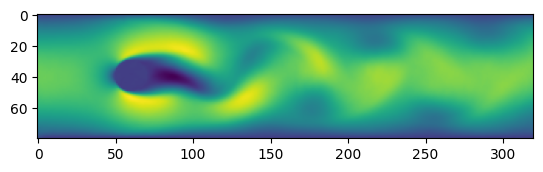

In [47]:
import matplotlib.tri as tri
cmap = "jet"
zeta = 10

coord = data["coord"]
face = data["cell_node_list"]

left, right = min(coord[:, 0]), max(coord[:, 0])
bottom, top = min(coord[:, 1]), max(coord[:, 1])
idx = 9

value = pred[0, :, :, idx, 0]
plt.imshow(value)